In [58]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [59]:
train_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv")
test_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv")
oil_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv")
stores_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")

In [60]:
train_df.sample(15)

,id,date,store_nbr,family,sales,onpromotion
552189,552189,2013-11-06,52,AUTOMOTIVE,0.000,0
109246,109246,2013-03-03,24,HOME AND KITCHEN II,0.000,0
1807259,1807259,2015-10-14,18,HARDWARE,0.000,0
573022,573022,2013-11-18,37,EGGS,166.000,0
2177114,2177114,2016-05-09,45,BREAD/BAKERY,1445.811,29
2046048,2046048,2016-02-26,18,HOME AND KITCHEN I,28.000,0
1887125,1887125,2015-11-27,9,LAWN AND GARDEN,2.000,0
702544,702544,2014-01-31,21,CLEANING,0.000,0
1465765,1465765,2015-04-05,36,BOOKS,0.000,0
573813,573813,2013-11-19,1,DELI,151.290,0


In [61]:
test_df.sample(15)

,id,date,store_nbr,family,onpromotion
4415,3005303,2017-08-18,32,PET SUPPLIES,0
24762,3025650,2017-08-29,53,GROCERY I,48
20980,3021868,2017-08-27,47,PERSONAL CARE,22
12143,3013031,2017-08-22,49,SEAFOOD,0
19444,3020332,2017-08-26,54,CLEANING,18
668,3001556,2017-08-16,28,DAIRY,151
14822,3015710,2017-08-24,25,BREAD/BAKERY,11
6656,3007544,2017-08-19,45,MAGAZINES,0
6622,3007510,2017-08-19,44,"LIQUOR,WINE,BEER",7
27849,3028737,2017-08-31,4,PRODUCE,1


In [62]:
duplicates = train_df[train_df.duplicated(subset=['date', 'store_nbr', "family"], keep=False)]
duplicates

,id,date,store_nbr,family,sales,onpromotion


In [63]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [64]:
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [65]:
oil_df["date"]=pd.to_datetime(oil_df["date"])

In [66]:
train_df["date"] = pd.to_datetime(train_df["date"])

In [67]:
train_df.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [68]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [69]:
correlation_with_prom = train_df["onpromotion"].corr(train_df["sales"])
correlation_with_prom

0.4279232048121313

In [70]:
correlation_with_oil = oil_df["dcoilwtico"].corr(train_df["sales"])
correlation_with_oil
#too low to use this feature in model

-0.049346765971872424

In [71]:
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [72]:
train_df = train_df.merge(stores_df, on="store_nbr", how="left").drop("id", axis=1)
test_df = test_df.merge(stores_df, on="store_nbr", how="left").drop("id", axis=1)

In [83]:
train_df.sample(10)

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,city_category
830813,2014-04-13,20,BREAD/BAKERY,0.000,0,Quito,Pichincha,B,6,4
2566257,2016-12-14,14,GROCERY I,2524.000,110,Riobamba,Chimborazo,C,7,2
2030319,2016-02-17,26,PLAYERS AND ELECTRONICS,4.000,0,Guayaquil,Guayas,D,10,3
3989,2013-01-03,20,PREPARED FOODS,0.000,0,Quito,Pichincha,B,6,4
2719969,2017-03-11,27,EGGS,247.000,0,Daule,Guayas,D,1,3
873333,2014-05-07,13,LINGERIE,8.000,0,Latacunga,Cotopaxi,C,15,2
2507368,2016-11-11,11,POULTRY,512.286,21,Cayambe,Pichincha,B,6,4
710707,2014-02-04,5,LADIESWEAR,0.000,0,Santo Domingo,Santo Domingo de los Tsachilas,D,4,2
1795599,2015-10-07,40,BEVERAGES,2529.000,18,Machala,El Oro,C,3,3
2461719,2016-10-16,30,HOME CARE,162.000,10,Guayaquil,Guayas,C,3,3


In [74]:
avg_sales_by_city= train_df.groupby("city")["sales"].mean().sort_values().reset_index()
avg_sales_by_city

,city,sales
0,Puyo,73.601845
1,Manta,125.173982
2,Playas,138.139340
3,Latacunga,190.583961
4,El Carmen,198.975799
5,Riobamba,204.921881
6,Salinas,205.517129
7,Ibarra,206.061866
8,Santo Domingo,214.942315
9,Guaranda,234.821670


Text(0, 0.5, 'Average sales')

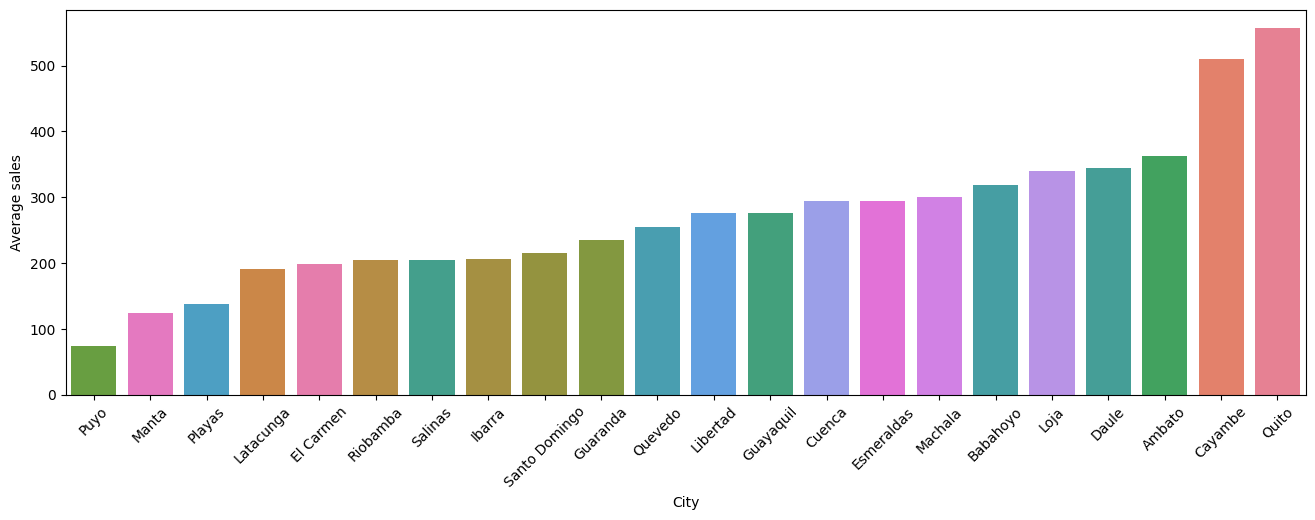

In [88]:
unique_cities = train_df['city'].unique()
color_palette = dict(zip(unique_cities, sns.color_palette("husl", n_colors=len(unique_cities))))
plt.figure(figsize=(16,5))
sns.barplot(x="city", y="sales", data=avg_sales_by_city, palette=color_palette)
plt.xticks(rotation=45)
plt.xlabel("City")
plt.ylabel("Average sales")



In [76]:
sorted_stores = train_df.groupby('store_nbr')['sales'].mean().sort_values().index
store_to_city = train_df.groupby('store_nbr')['city'].first()
store_colors = [color_palette[store_to_city[store]] for store in sorted_stores]

In [85]:
store_to_city

store_nbr
1             Quito
2             Quito
3             Quito
4             Quito
5     Santo Domingo
6             Quito
7             Quito
8             Quito
9             Quito
10            Quito
11          Cayambe
12        Latacunga
13        Latacunga
14         Riobamba
15           Ibarra
16    Santo Domingo
17            Quito
18            Quito
19         Guaranda
20            Quito
21    Santo Domingo
22             Puyo
23           Ambato
24        Guayaquil
25          Salinas
26        Guayaquil
27            Daule
28        Guayaquil
29        Guayaquil
30        Guayaquil
31         Babahoyo
32        Guayaquil
33          Quevedo
34        Guayaquil
35           Playas
36         Libertad
37           Cuenca
38             Loja
39           Cuenca
40          Machala
41          Machala
42           Cuenca
43       Esmeraldas
44            Quito
45            Quito
46            Quito
47            Quito
48            Quito
49            Quito
50        

Text(0, 0.5, 'Sum of sales')

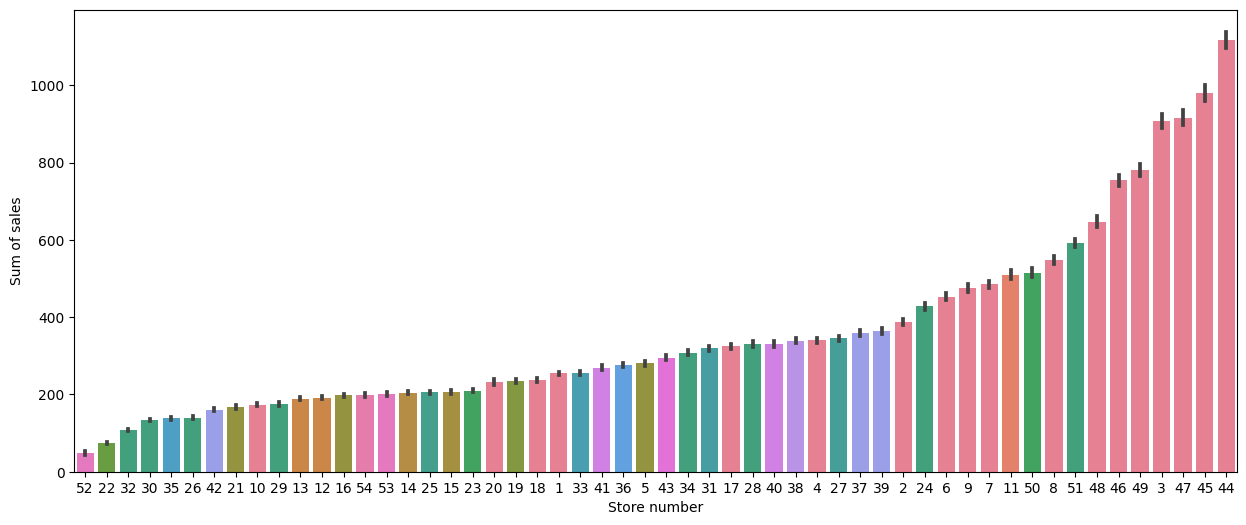

In [82]:
plt.figure(figsize=(15,6))
sns.barplot(data=train_df, x="store_nbr", y="sales", order=sorted_stores, palette=store_colors)
plt.xlabel("Store number")
plt.ylabel("Sum of sales")
#thinning this categorical feature can't be done by cities according to color coding, grouping them by mean sales value by store is a better metric

In [78]:
train_df["city_category"]  = train_df["city"].map(city_to_category)

In [79]:
train_df.head()

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,city_category
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,4
1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,4
2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,4
3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,4
4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,4


<Axes: xlabel='family', ylabel='sales'>

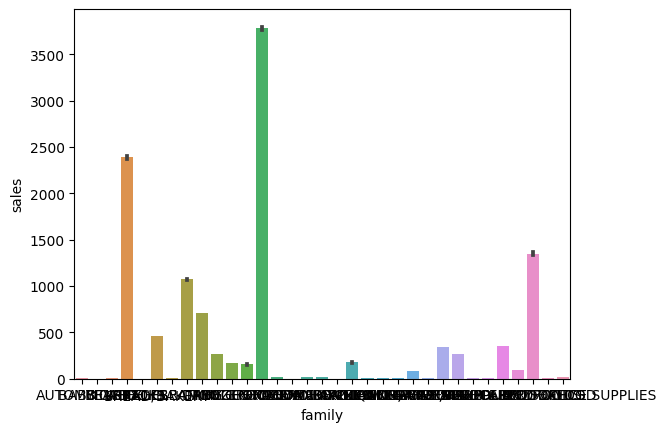

In [80]:
sns.barplot(data=train_df, x="family", y="sales")

In [81]:
avg_sales_by_family= train_df.groupby("family")["sales"].mean().sort_values().reset_index()
avg_sales_by_family

,family,sales
0,BOOKS,0.070797
1,BABY CARE,0.110528
2,HOME APPLIANCES,0.457476
3,HARDWARE,1.137833
4,MAGAZINES,2.929082
5,SCHOOL AND OFFICE SUPPLIES,2.961599
6,BEAUTY,3.715723
7,PET SUPPLIES,3.921263
8,LAWN AND GARDEN,6.035475
9,AUTOMOTIVE,6.101236
